<a href="https://colab.research.google.com/github/nikitazharkovsky/ML/blob/main/AI_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №2
### Прогнозирование временных рядов с помощью аппарата ИНС
Подготовили: Поминова Алёна, Жарковский Никита, Цыганкова Елизавета 

TODO: удалить
Источник http://www.bizkit.ru/2019/11/11/15143/

In [1]:
from google.colab import files
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, SimpleRNN
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from keras.layers.convolutional import Conv1D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv1D, Dense, MaxPool1D, Flatten, Input


In [2]:
#Считываем данные с помощью pandas
base_data = pd.read_csv('lab2.csv', sep=',')
print(base_data.shape)

#Выводим пять первых строк
base_data.head()

(200, 7)


,ti,f,empty,x1,x2,x3,y
0,0.0,0.000000,NaN,0.000000,0.998334,1.986693,6.442177
1,0.1,0.998334,NaN,0.998334,1.986693,2.955202,7.173561
2,0.2,1.986693,NaN,1.986693,2.955202,3.894183,7.833269
3,0.3,2.955202,NaN,2.955202,3.894183,4.794255,8.414710
4,0.4,3.894183,NaN,3.894183,4.794255,5.646425,8.912074


# Подготовка данных

In [3]:
#Загружаем выборку и делаем предобработку, убрав 3 первые колонки
def getData(df):
  data = df
  return data.drop(columns=['ti', 'f', 'empty'], axis=1).astype(float)
#Получаем данные из файла
def getDataFromFile(fileName):
  df = pd.read_csv(fileName, sep=',') #Считываем файл с помощью pandas
  return getData(df) #Возвращаем считанные данные из файла

In [4]:
#Считываем данные из файла
data = getDataFromFile('lab2.csv')
print(data.head(5))
print(data.shape)

         x1        x2        x3         y
0  0.000000  0.998334  1.986693  6.442177
1  0.998334  1.986693  2.955202  7.173561
2  1.986693  2.955202  3.894183  7.833269
3  2.955202  3.894183  4.794255  8.414710
4  3.894183  4.794255  5.646425  8.912074
(200, 4)


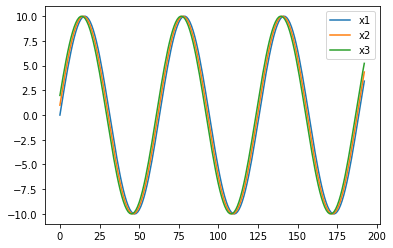

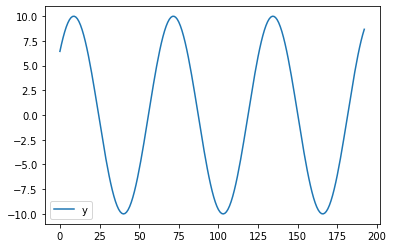

In [5]:
#Отображаем исходные данные от точки start и длиной step
start = 0 #С какой точки начинаем
step = data.shape[0] #Сколько точек отрисуем
#Заполняем текстовые названия каналов данных
chanelNames = list(data.columns) # ['Open', 'Max', 'Min', 'Close', 'Volume']
#Рисуем все графики данных
#Четыре основных канала - open, max, min, close
for i in range(3):
  #Отрисовываем часть данных
  #От начальной точки, до начальной точки + размер шага отрисовки
  plt.plot(data.iloc[start:start+step, i], label=chanelNames[i])
plt.legend()
plt.show()
#Канал volume
plt.plot(data.iloc[start:start+step, 3], label="y")
plt.legend()
plt.show()

# Проверка алгоритма подготовки данных

In [6]:
num = 20 
xData = np.arange(0, num).reshape(num,1)
print(xData)
stepsForward = 1
xLen = 5
xChannels = 0
print("xData.shape", xData.shape)
print("Range:", xData.shape[0] - xLen + 1 - stepsForward)

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]]
xData.shape (20, 1)
Range: 15


In [7]:
#Исходную последователность преобразуем в массив «раскусыванием»:

xTrain = np.array([xData[i:i + xLen, xChannels] for i in range(xData.shape[0] - xLen + 1 - stepsForward)])
print("xTrain.shape:", xTrain.shape)
print("xTrain:\r\n", xTrain)

xTrain.shape: (15, 5)
xTrain:
 [[ 0  1  2  3  4]
 [ 1  2  3  4  5]
 [ 2  3  4  5  6]
 [ 3  4  5  6  7]
 [ 4  5  6  7  8]
 [ 5  6  7  8  9]
 [ 6  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 12]
 [ 9 10 11 12 13]
 [10 11 12 13 14]
 [11 12 13 14 15]
 [12 13 14 15 16]
 [13 14 15 16 17]
 [14 15 16 17 18]]


In [8]:
yChannels = [0]
yData = xData
if (stepsForward > 1):
  yTrain = np.array([yData[i:i + stepsForward, yChannels] for i in range(xLen, yData.shape[0] + 1 - stepsForward)])
else:
  yTrain = np.array([yData[i, yChannels] for i in range(xLen, yData.shape[0] + 1 - stepsForward)])
print("yTrain.shape", yTrain.shape)
print("yTrain:\r\n", yTrain)  

yTrain.shape (15, 1)
yTrain:
 [[ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]]


In [9]:
valLen = 3
#Расчитываем отступ между обучающими о проверочными данными,  чтобы они не смешивались
xTrainLen = xTrain.shape[0]
bias = xLen + stepsForward + 2 #Выбрасываем bias записей. Небольшой резерв на 2 записи
print("xTrainLen:", xTrainLen)
print("bias:", bias)
#Берём из конечной части xTrain проверочную выборку
xVal = xTrain[xTrainLen-valLen:]
yVal = yTrain[xTrainLen-valLen:]
  
print("xVal:\r\n", xVal)
print("yVal:\r\n", yVal)

xTrainLen: 15
bias: 8
xVal:
 [[12 13 14 15 16]
 [13 14 15 16 17]
 [14 15 16 17 18]]
yVal:
 [[17]
 [18]
 [19]]


In [10]:
#Оставшуюся часть используем под обучающую выборку
xTrain1 = xTrain[:xTrainLen-valLen-bias]
yTrain1 = yTrain[:xTrainLen-valLen-bias]
print("xTrain:\r\n", xTrain1)
print("yTrain:\r\n", yTrain1)

xTrain:
 [[0 1 2 3 4]
 [1 2 3 4 5]
 [2 3 4 5 6]
 [3 4 5 6 7]]
yTrain:
 [[5]
 [6]
 [7]
 [8]]


# Код подготовки данных для временного ряда

In [11]:
#data - Numpy array
def DataNormalization(data, Channels, Normalization):
  #Выбираем тип нормализации x
  #0 - нормальное распределение
  #1 - нормирование до отрезка 0-1
  if (Normalization == 0):
    scaler = StandardScaler()
  else:
    scaler = MinMaxScaler()
  
  #Берём только те каналы, которые указаны в аргументе функции
  resData = data.iloc[:,Channels]
  if (len(resData.shape) == 1): #Если размерность входного массива - одномерный вектор, 
    print("Add one dimension")
    resData = np.expand_dims(resData, axis=1) #то добавляем размерность
  #Обучаем нормировщик
  scaler.fit(resData)
  #Нормируем данные
  resData = scaler.transform(resData)
  return (resData, scaler)

In [12]:
#Функция "раскусывания" данных для временных рядов
#data - данные
#xLen - размер фрема, по которому предсказываем
#xChannels - лист, номера каналов, по которым делаем анализ
#yChannels - лист, номера каналов, которые предсказываем
#stepsForward - на сколько шагов предсказываем в будущее
#если 1 - то на 1 шаг, можно использовать только при одном канале, указанном в yChannels
#xNormalization - нормализация входных каналов, 0 - нормальное распределение, 1 - к отрезку [0;1]
#yNormalization - нормализация прогнозируемых каналов, 0 - нормальное распределение, 1 - к отрезку [0;1]
#returnFlatten - делать ли одномерный вектор на выходе для Dense сетей
#valLen - сколько примеров брать для проверочной выборки (количество для обучающей посчитается автоматиески)
#convertToDerivative - bool, преобразовывали ли входные сигналы в производнуюa
def getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative):
  
  #Если указано превращение данных в производную
  #То вычитаем поточечно из текущей точки предыдущую
  if (convertToDerivative):
    data = np.array([(d[1:]-d[:-1]) for d in data.T]).copy().T
  
  #Нормализуем x
  (xData, xScaler) = DataNormalization(data, xChannels, xNormalization)
  #Нормализуем y
  (yData, yScaler) = DataNormalization(data, yChannels, yNormalization)
  #Формируем xTrain
  #Раскусываем исходный ряд на куски xLen с шагом в 1
  xTrain = np.array([xData[i:i + xLen, xChannels] for i in range(xData.shape[0] - xLen + 1 - stepsForward)])
  
  #Формируем yTrain
  #Берём stepsForward шагов после завершения текущего x
  if (stepsForward > 1):
    yTrain = np.array([yData[i:i + stepsForward, yChannels] for i in range(xLen, yData.shape[0] + 1 - stepsForward)])
  else:
    yTrain = np.array([yData[i, yChannels] for i in range(xLen, yData.shape[0] + 1 - stepsForward)])
  #Расчитываем отступ между обучающими о проверочными данными
  #Чтобы они не смешивались
  xTrainLen = xTrain.shape[0]
  bias = xLen + stepsForward + 2
  #Берём из конечной части xTrain проверочную выборку
  xVal = xTrain[xTrainLen-valLen:]
  yVal = yTrain[xTrainLen-valLen:]
  
  #Оставшуюся часть используем под обучающую выборку
  xTrain = xTrain[:xTrainLen-valLen-bias]
  yTrain = yTrain[:xTrainLen-valLen-bias]
  #Если в функцию передали вернуть flatten сигнал (для Dense сети)
  #xTrain и xVal превращаем в flatten
  if (returnFlatten > 0):
    xTrain = np.array([x.flatten() for x in xTrain])
    xVal = np.array([x.flatten() for x in xVal])
  return (xTrain, yTrain), (xVal, yVal), (xScaler, yScaler)

In [13]:
#Формируем параметры загрузки данных
xLen = 100
stepsForward = 5
xChannels = range(data.shape[1])
yChannels = [0]
xNormalization = 0
yNormalization = 0
valLen = 20
returnFlatten = 0 #Возвращаем двумерные данные для свёртки
convertToDerivative = 0
#Загружаем данные
(xTrain, yTrain), (xVal, yVal), (xScaler, yScaler) = getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative)
#Выводим размеры данных для проверки
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(65, 100, 4)
(65, 5, 1)
(20, 100, 4)
(20, 5, 1)


Epoch 1/20
4/4 [==============================] - 0s 53ms/step - loss: 1.1752 - val_loss: nan
Epoch 2/20
4/4 [==============================] - 0s 16ms/step - loss: 0.7345 - val_loss: nan
Epoch 3/20
4/4 [==============================] - 0s 16ms/step - loss: 0.5295 - val_loss: nan
Epoch 4/20
4/4 [==============================] - 0s 16ms/step - loss: 0.3097 - val_loss: nan
Epoch 5/20
4/4 [==============================] - 0s 15ms/step - loss: 0.1683 - val_loss: nan
Epoch 6/20
4/4 [==============================] - 0s 16ms/step - loss: 0.0858 - val_loss: nan
Epoch 7/20
4/4 [==============================] - 0s 16ms/step - loss: 0.0281 - val_loss: nan
Epoch 8/20
4/4 [==============================] - 0s 17ms/step - loss: 0.0081 - val_loss: nan
Epoch 9/20
4/4 [==============================] - 0s 17ms/step - loss: 0.0049 - val_loss: nan
Epoch 10/20
4/4 [==============================] - 0s 17ms/step - loss: 0.0073 - val_loss: nan
Epoch 11/20
4/4 [==============================] - 0s 17ms/

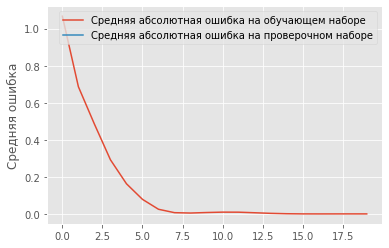

In [18]:
modelC = Sequential()
modelC.add(Conv1D(50, 5, input_shape = (xTrain.shape[1], xTrain.shape[2]), activation="linear"))
modelC.add(Flatten())
modelC.add(Dense(10, activation="linear"))
modelC.add(Dense(yTrain.shape[1], activation="linear"))
modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))
history = modelC.fit(xTrain, 
                    yTrain, 
                    epochs=20, 
                    batch_size=20, 
                    verbose=1,
                    validation_data=(xVal, yVal))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

# Визуализация результатов

In [15]:
#Функция рассчитываем результаты прогнозирования сети
#В аргументы принимает сеть (currModel) и проверочную выборку
#Выдаёт результаты предсказания predVal
#И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  #Предсказываем ответ сети по проверочной выборке
  #И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)
#Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  return np.corrcoef(a, b)[0, 1] 
#Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
#start - точка с которой начинаем отрисовку графика
#step - длина графика, которую отрисовываем
#channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
#Функция рисуем корреляцию прогнозированного сигнала с правильным
#Смещая на различное количество шагов назад
#Для проверки появления эффекта автокорреляции
#channels - по каким каналам отображать корреляцию
#corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  #Проходим по всем каналам
  for ch in channels:
    corr = [] #Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] #Запоминаем размер проверочной выборки
    #Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      #Получаем сигнал, смещённый на i шагов назад
      #predVal[i:, ch]
      #Сравниваем его с верными ответами, без смещения назад
      #yValUnscaled[:yLen-i,ch]
      #Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))
    #Отображаем график коррелций для данного шага
    plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [16]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler)

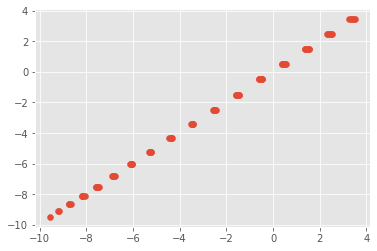

In [17]:
import matplotlib
matplotlib.style.use('ggplot')
plt.scatter(predVal, yValUnscaled)
plt.show()